# Deep Ritz method and PINN for solving PDEs with nonsmooth solutions

考虑如下 Poisson 方程
$$
\left\{
    \begin{aligned}
        - \Delta u &= 1, & & x \in \Omega \\
        u (x) &= 0 & & x \in \partial \Omega
    \end{aligned}
\right.
$$
其中 $\Omega = (-1, 1) \times (-1, 1) \setminus [0, 1) \times \{ 0 \}$.

首先，我们引入一些必要的 python packages，其中包括最重要的深度学习框架 PyTorch 相关的两个 package: torch 以及 torch 的子模块 torch.nn

In [1]:
#!-*- coding:utf-8 -*-
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)

我们将首先熟悉深度学习框架 PyTorch，并在之后基于该框架构建 PDE 数值求解模型

<img src="https://meterpreter.org/wp-content/uploads/2017/12/pytorch-logo-dark.png" title="Image source: https://meterpreter.org/wp-content/uploads/2017/12/pytorch-logo-dark.png">

> END-TO-END MACHINE LEARNING FRAMEWORK

> PyTorch enables fast, flexible experimentation and efficient production through a user-friendly front-end, distributed training, and ecosystem of tools and libraries.

PyTorch 主页: https://pytorch.org/

PyTorch 中文手册: https://pytorch-cn.readthedocs.io/zh/latest/

首先我们介绍在 PyTorch 中如何自定义神经网络的构件。

1. 首先，所有的 PyTorch 神经网络层都必须继承自 `torch.nn` 下的 `Module` 模块
2. 所有和层有关的参数在自定义层的 `__init__` 函数中定义
3. 所有自定义层都必须重写 `forward` 函数，从而完成这个层的功能

我们通过下面自定义的激活函数的例子来帮助大家理解上面的具体过程。在这里，我们使用 Deep Ritz Method [原文](https://arxiv.org/abs/1710.00211) 中使用的激活函数，即，
$$
\sigma (x) = \max (x^{3}, 0)
$$

In [2]:
class Act(nn.Module):
    # 初始化函数，这里的激活层没有参数
    def __init__(self) -> None:
        super().__init__()

    # forward 函数，输入为 x
    def forward(self, x):
        a = torch.pow(x, 3.0)               # torch.pow(x)是 torch 中的幂次函数，这里返回 x^{3}
        b = torch.zeros_like(x)             # torch.zeros_like(x) 会生成一个和 x 形状相同的全零 tensor
        out = torch.maximum(a, b)           # torch.maximum(a, b)会逐元素返回 a, b 中较大的值
        
        return out

我们进一步通过下面这个具有 skip connection 的结构来理解如何自定义 PyTorch 的神经网络层。其中，我们将使用 torch 中的一些自定义模块：
1. `nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)`: 
    - in_features: <font color=#FF0000>必选参数</font>，输入数据的维度
    - out_features: <font color=#FF0000>必选参数</font>，输出数据的维度
    - bias: <font color=#0000FF>可选参数</font>，是否使用偏置
    - device: <font color=#0000FF>可选参数</font>，实现的硬件，可以是 torch.device("cpu")或者torch.device("cuda:0")等
    - dtype: <font color=#0000FF>可选参数</font>，数据的类型，可以是 torch.float64, torch.int32 等
2. `nn.Sequential(*args)`: 
    - 括号内每一项都是一个 `nn.Module`，可以构成多个层的一个整体

具有 skip connection 结构的神经网络层的数学定义如下：

$$
y = x + \sigma (w_{2} \sigma (w_{1} x + b_{1}) + b_{1})
$$

因此，我们可以通过下面的方式来实现它

In [3]:
class Block(nn.Module):
    def __init__(self, m:int) -> None:
        super().__init__()

        self.l1 = nn.Sequential(nn.Linear(m, m), Act())   # linear 层定义了线性部分，act 定义了非线性激活部分
        self.l2 = nn.Sequential(nn.Linear(m, m), Act())   # 同上

    def forward(self, x):

        y = self.l1(x)  # \sigma(w_{1} x + b_{1})
        y = self.l2(y)  # \sigma(w_{2} x + b_{2})
        y = y + x       # skip connection

        return y

接下来，通过多次堆叠上面定义好的`Block`类，结合Deep Ritz Method [原文](https://arxiv.org/abs/1710.00211)，就可以构造出一个能够用于数值求解 PDE 的完整神经网络了。

<center>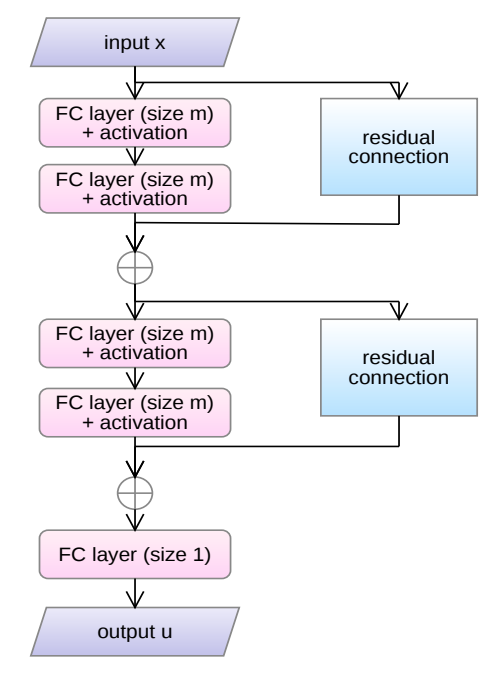</center>

In [4]:
class Net(nn.Module):
    def __init__(self, d, m, n) -> None:
        super().__init__()
        
        # input transformation
        if d < m:
            pl = (m - d) // 2
            pr = m - d - pl
            self.input_transform = lambda x: nn.functional.pad(x, (pl, pr), "constant", 0)    # 将 d-维数据通过补 0 方式扩充到 m-维数据
            # nn.functional.pad: https://pytorch.org/docs/stable/generated/torch.nn.functional.pad.html

        elif d > m:
            self.input_transform = nn.Linear(d, m)    # 将d-维数据线性映射到 m-维数据

        else:
            self.input_transform = nn.Identity()      # 保持输入不变

        self.z = nn.ModuleList([Block(m) for _ in range(n)])    # 堆叠多个 Block

        self.last = nn.Linear(m, 1)  # 最后线性映射到 1 维输出

    def forward(self, x):

        z = self.input_transform(x)  # 输入变换

        for m in self.z:             # 经过具有不同参数的 n 个 Block 层
            z = m(z)
        
        out = self.last(z)           # 最后输出

        return out

完成对神经网络的构造后，我们需要构造关于神经网络参数的损失函数，通过最优化这样的损失来找到最优的参数。在这里，我们首先给出 Deep Ritz Method [原文](https://arxiv.org/abs/1710.00211) 的优化过程，从而帮助大家对如何构造深度学习的优化进行了解。

神经网络的优化过程包括下面这些关键步骤：
1. 找到需要优化的参数，一般神经网络的全部参数都可以优化
2. 定义优化器，可以从 torch.optim.optimizer 中选择
3. 定义学习率，可以从 torch.optim.lr_scheduler 中选择
4. 在每一步迭代中：
    1. 归零所有参数在上一轮迭代中产生的梯度
    2. 计算神经网络的输出
    3. 计算损失函数
    4. 通过对损失函数进行反向传播，即调用 .backward() 方法来获得梯度 (<font color=#FF0000>注意，这里 PyTorch 通过自动微分机制自动求导，本质上在进行课程中的反向传播</font>)
    5. 通过优化器更新神经网络参数

In [5]:

class DeepRitz(nn.Module):
    def __init__(self, d, m, n, beta) -> None:
        super().__init__()

        self.beta = beta         # 边界项的权重
        self.net = Net(d, m, n)  # 定义求解 PDE 所需的神经网络

        print(f"num of parameters: {sum([p.numel() for p in self.net.parameters()])}")  # 输出神经网络的参数数目

    def train_problem(self, problem, steps, in_bs, bd_bs, lr, opt_type="adam", log_every=1000, save_every=1000, save_dir=None):

        # 构造优化器
        if opt_type == "sgd":
            opt = torch.optim.SGD(self.net.parameters(), lr=lr)   # 选择模型的全部参数，并使用 SGD 优化器优化
        elif opt_type == "adam":
            opt = torch.optim.Adam(self.net.parameters(), lr=lr, betas=(0.5, 0.999))    # 选择模型的全部参数，并使用 Adam 优化器优化
        else:
            raise ValueError

        # 构造学习率
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=2 * steps // 5, gamma=0.2)

        train_loss_inner = list()
        train_loss_bound = list()
        
        # 训练循环 steps 次
        for step in range(steps):
        
            # 归零化所有参数的梯度
            opt.zero_grad()

            # 计算初值条件的输出与误差
            x_in = problem.sample_inner(in_bs)                     # 采样初时的样本
            x_in = torch.from_numpy(x_in).requires_grad_(True)     # 将其转换为 torch 的数据结构，并设为可求梯度
            u_in = self.net(x_in)                                  # 计算神经网络输出
            loss_in = problem.ritz_loss_inner(u_in, x_in)          # 计算神经网络参数的损失

            # 计算边界条件的输出与误差
            x_bd = problem.sample_boundary(bd_bs)                  # 采样边界的样本
            x_bd = torch.from_numpy(x_bd).requires_grad_(True)
            u_bd = self.net(x_bd)
            loss_bd = problem.ritz_loss_boundary(u_bd, x_bd)

            loss = loss_in.mean() + self.beta * loss_bd.mean()     # 计算总体损失
            loss.backward()                                        # 反向传播，获得参数的梯度
            
            train_loss_inner.append(loss_in.mean().item())
            train_loss_bound.append(loss_bd.mean().item())
            
            # 这是一步技巧，通过裁剪掉模长过大的梯度，可以稳定训练过程
            torch.nn.utils.clip_grad_norm_(parameters=self.net.parameters(), max_norm=10, norm_type=2)

            # 通过优化器更新神经网络参数
            opt.step()

            # 记录中间结果
            if (step + 1) % log_every == 0:
                print(f"[{step + 1:d}/{steps:d}]: total loss: {loss.item():.2f}, inner loss: {loss_in.mean().item():.2f}, boundary loss: {loss_bd.mean().item():.2f}")

            # 保存中间模型
            if save_dir is not None and (step + 1) % save_every == 0:
                torch.save(self.state_dict(), f"{save_dir}/step-{step + 1:d}.pth")

            # 更新学习率
            lr_scheduler.step()
            
        fig, ax = plt.subplots()
        fig.set_tight_layout(True)
        
        s = np.arange(steps)
        plt.plot(s, train_loss_inner, label="pde loss")
        plt.plot(s, train_loss_bound, label="boundary loss")
        
        ax.legend(loc="upper right")
        
        plt.show()


同样地，我们给出 PINN [原文](https://www.sciencedirect.com/science/article/pii/S0021999118307125) 的优化过程。这里和 Deep Ritz Method 的结果完全一致，仅在损失函数的定义上有不同

In [6]:

class PINN(nn.Module):
    def __init__(self, d, m, n, beta) -> None:
        super().__init__()

        self.beta = beta
        self.net = Net(d, m, n)

        print(f"num of parameters: {sum([p.numel() for p in self.net.parameters()])}")

    def train_problem(self, problem, steps, in_bs, bd_bs, lr, opt_type="adam", log_every=1000):

        # build the optimizer
        if opt_type == "sgd":
            opt = torch.optim.SGD(self.net.parameters(), lr=lr)
        elif opt_type == "adam":
            opt = torch.optim.Adam(self.net.parameters(), lr=lr, betas=(0.5, 0.999))
        else:
            raise ValueError

        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=2 * steps // 5, gamma=0.2)
        
        train_loss_inner = list()
        train_loss_bound = list()

        # train loop
        for step in range(steps):

            opt.zero_grad()

            # inner conditions
            x_in = problem.sample_inner(in_bs)
            x_in = torch.from_numpy(x_in).requires_grad_(True)
            u_in = self.net(x_in)
            loss_in = problem.pinn_loss_inner(u_in, x_in)

            # boundary conditions
            x_bd = problem.sample_boundary(bd_bs)
            x_bd = torch.from_numpy(x_bd).requires_grad_(True)
            u_bd = self.net(x_bd)
            loss_bd = problem.pinn_loss_boundary(u_bd, x_bd)

            loss = loss_in.mean() + self.beta * loss_bd.mean()
            train_loss_inner.append(loss_in.mean().item())
            train_loss_bound.append(loss_bd.mean().item())
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(parameters=self.net.parameters(), max_norm=10, norm_type=2)

            opt.step()

            if (step + 1) % log_every == 0:
                print(f"[{step + 1:d}/{steps:d}]: total loss: {loss.item():.2e}, inner loss: {loss_in.mean().item():.2e}, boundary loss: {loss_bd.mean().item():.2e}")

            lr_scheduler.step()
            
        fig, ax = plt.subplots()
        fig.set_tight_layout(True)
        
        s = np.arange(steps)
        plt.plot(s, train_loss_inner, label="pde loss")
        plt.plot(s, train_loss_bound, label="boundary loss")
        
        ax.legend(loc="upper right")
        
        plt.show()


不同于一般的机器学习问题，用于求解 PDE 的机器学习方法的损失函数一般都是与问题有关的，例如，需要判断问题的边界条件类型，不同的 PDE 也将导致不同的损失，等等。因此，我们基于所考虑的问题，定义 Deepp Ritz Method 以及 PINN 所需要的损失函数:
- Deep Ritz Method 的损失函数定义如下：
$$
\min_{\theta} \frac{1}{N_{in}} \sum_{i=1}^{N_{in}} \frac{1}{2} |\nabla u (x_{i}; \theta)|^{2} - u (x_{i}; \theta) + \frac{\beta}{N_{bd}} \sum_{j=1}^{N_{bd}} u (x_{i}; \theta)^{2}
$$
- PINN 的损失函数定义如下：
$$
\min_{\theta} \frac{1}{N_{in}} \sum_{i=1}^{N_{in}} (-\Delta u (x_{i}; \theta) - 1)^{2} + \frac{\beta}{N_{bd}} \sum_{j=1}^{N_{bd}} u (x_{i}; \theta)^{2}
$$

In [7]:

class Nonsmooth_Problem(object):
    def __init__(self) -> None:
        
        # 构造问题的相关参数
        self.dim = 2
        self.x0 = -1.0
        self.x1 = 1.0
        self.y0 = -1.0
        self.y1 = 1.0

    # 内部点的采样方法
    def sample_inner(self, n, eps=1e-7):
        
        x = np.random.uniform(low=[self.x0 + eps, self.y0 + eps], high=[self.x1 - eps, self.y1 - eps], size=(2 * n, 2))

        return x[:n]

    # 边界点的采样方法
    def sample_boundary(self, n):
        
        a = n // 9
        b = np.ones((2 * a, 1))
        r = np.random.uniform(low=-1, high=1, size=(n, 1))
        x = list()
        x.append(np.hstack([r[0 * a: 2 * a], b * self.y0]))
        x.append(np.hstack([b * self.x1, r[2 * a: 4 * a]]))
        x.append(np.hstack([r[4 * a: 6 * a], b * self.y1]))
        x.append(np.hstack([b * self.x0, r[6 * a: 8 * a]]))
        x.append(np.hstack([(r[8 * a:] + 1) / 2, np.zeros((n - 8 * a, 1))]))
        x = np.concatenate(x, axis=0)

        return x
    
    # PDE 右端项
    def f(self, x):

        return 1
    
    # 初时条件右端项
    def g(self, x):

        return 0

    # DRM PDE损失函数
    def ritz_loss_inner(self, u, x):
        
        # 求解一阶导数
        du = torch.autograd.grad(outputs=u[:, 0], inputs=x, 
                                 grad_outputs=torch.ones_like(u[:, 0]), 
                                 retain_graph=True, create_graph=True)[0]
        
        # 求解 PDE 右端项输出
        fx = self.f(x)
        
        # 计算弱形式损失
        loss = torch.sum(torch.square(du), dim=1, keepdim=True) / 2 - fx * u
        
        return loss

    # DRM 边界损失函数
    def ritz_loss_boundary(self, u, x):
        
        # 计算边界右端项输出
        g = self.g(x)
        
        # 计算边界损失
        loss = torch.square(u - g)
        
        return loss

    # PINN PDE损失函数
    def pinn_loss_inner(self, u, x):
        
        # 求解一阶导数
        du = torch.autograd.grad(outputs=u[:, 0], inputs=x, 
                                 grad_outputs=torch.ones_like(u[:, 0]), 
                                 retain_graph=True, create_graph=True)[0]

        d2u = torch.zeros(x.size(0))
        
        # 求解二阶导数
        for d in range(self.dim):
            d2u += torch.autograd.grad(outputs=du[:, d], inputs=x, 
                                       grad_outputs=torch.ones_like(du[:, d]), 
                                       retain_graph=True, create_graph=True)[0][:, d]
        
        # 求解 PDE 右端项输出
        fx = self.f(x)

        # 计算强形式损失
        loss = torch.square(-d2u - fx).view(-1, 1)
        
        return loss

    # PINN 边界损失函数
    def pinn_loss_boundary(self, u, x):

        # 计算边界右端项输出
        g = self.g(x)
        
        # 计算边界损失
        loss = torch.square(u - g)
        
        return loss

接下来，我们定义一个固定随机种子的函数，并给出问题求解的相关超参数

In [8]:
def set_seed(x):
    np.random.seed(x)
    torch.manual_seed(x)
    torch.cuda.manual_seed_all(x)
    torch.backends.cudnn.deterministic = True

torch.set_default_dtype(torch.float64)

set_seed(100)

# hyper-parameters
dim = 2               # 问题的维度
in_bs = 1000          # 优化中内点采样数
bd_bs = 1000          # 优化中边界点采样数
lr = 1e-3             # 初时学习率
num_steps = 50000     # 训练总步数
log_every = 10000     # 打印中间结果间隔数
num_sample_x = 80     # 测试 x-方向采样数
num_sample_y = 80     # 测试 y-方向采样数

首先，我们实例化这个具有非光滑解的问题，并可视化内点以及边界点的采样结果

/tmp/ipykernel_2670703/3536275686.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


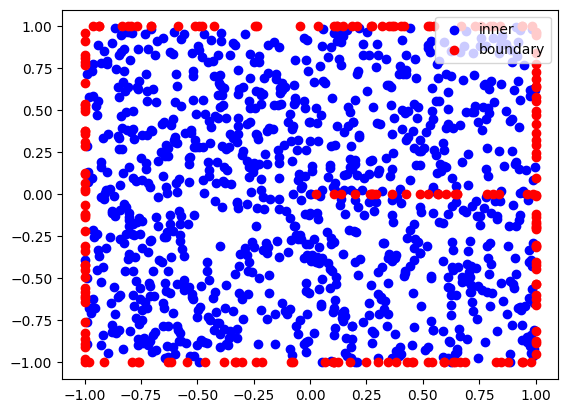

In [9]:

problem = Nonsmooth_Problem()

x_in = problem.sample_inner(n=1000)
x_bd = problem.sample_boundary(n=200)
    
fig, ax = plt.subplots()
ax.scatter(x_in[:, 0], x_in[:, 1], c="blue", label="inner")
ax.scatter(x_bd[:, 0], x_bd[:, 1], c="red", label="boundary")
ax.legend(loc="upper right")

fig.show()


我们构造 Deep Ritz Method 模型，并进行训练

num of parameters: 891
[10000/50000]: total loss: -0.04, inner loss: -0.04, boundary loss: 0.00
[20000/50000]: total loss: -0.04, inner loss: -0.05, boundary loss: 0.00
[30000/50000]: total loss: -0.04, inner loss: -0.05, boundary loss: 0.00
[40000/50000]: total loss: -0.05, inner loss: -0.05, boundary loss: 0.00
[50000/50000]: total loss: -0.04, inner loss: -0.05, boundary loss: 0.00


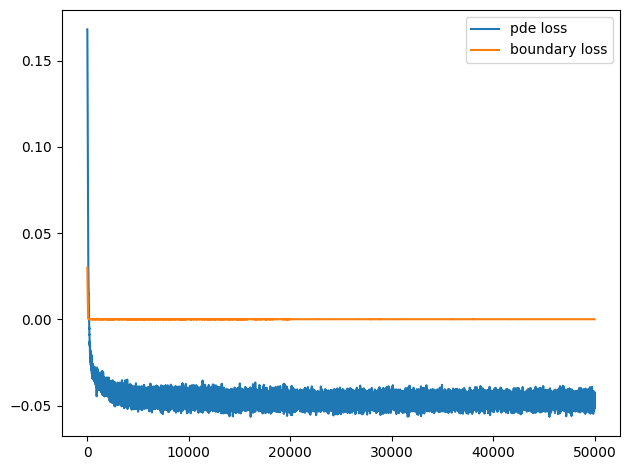

In [10]:

deepritz = DeepRitz(d=dim, m=10, n=4, beta=100)

deepritz.train_problem(problem=problem, steps=num_steps, in_bs=in_bs, bd_bs=bd_bs, lr=lr, opt_type="adam", log_every=log_every)


在测试点上计算网络的结果，并可视化结果

/tmp/ipykernel_2670703/2046070995.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


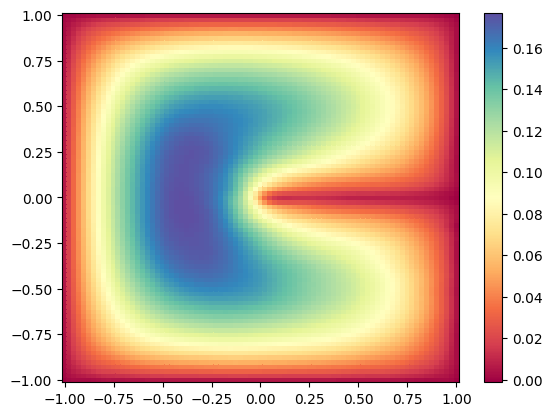

In [11]:

x_grid = np.linspace(start=problem.x0, stop=problem.x1, num=num_sample_x + 1, endpoint=True).reshape(-1, 1).repeat(num_sample_y + 1, axis=1)
y_grid = np.linspace(start=problem.y0, stop=problem.y1, num=num_sample_y + 1, endpoint=True).reshape(1, -1).repeat(num_sample_x + 1, axis=0)
grid = np.stack((x_grid, y_grid), axis=2)

deepritz.net.eval()
with torch.no_grad():
    u_grid = deepritz.net(torch.from_numpy(grid)).detach().numpy()

fig, ax = plt.subplots()

im = ax.pcolor(grid[:, :, 0], grid[:, :, 1], u_grid[:, :, 0], cmap="Spectral")
fig.colorbar(im)

fig.show()


输出网路训练完成后 PDE 弱形式损失以及边界损失

In [12]:

in_size = 1000
bd_size = 200

# inner conditions
x_in = problem.sample_inner(in_size)
x_in = torch.from_numpy(x_in).requires_grad_(True)
u_in = deepritz.net(x_in)
loss_in = problem.ritz_loss_inner(u_in, x_in)

# boundary conditions
x_bd = problem.sample_boundary(bd_size)
x_bd = torch.from_numpy(x_bd).requires_grad_(True)
u_bd = deepritz.net(x_bd)
loss_bd = problem.ritz_loss_boundary(u_bd, x_bd)

print(f"loss inner: {loss_in.mean()}")
print(f"loss bound: {loss_bd.mean()}")

loss inner: -0.04389418535393163
loss bound: 3.9625527764743306e-05


我们构造 PINN 模型，并进行训练

num of parameters: 891
[10000/50000]: total loss: 4.65e-01, inner loss: 4.04e-01, boundary loss: 6.17e-05
[20000/50000]: total loss: 4.30e-01, inner loss: 3.81e-01, boundary loss: 4.95e-05
[30000/50000]: total loss: 4.25e-01, inner loss: 3.76e-01, boundary loss: 4.96e-05
[40000/50000]: total loss: 4.73e-01, inner loss: 4.20e-01, boundary loss: 5.30e-05
[50000/50000]: total loss: 4.37e-01, inner loss: 3.82e-01, boundary loss: 5.47e-05


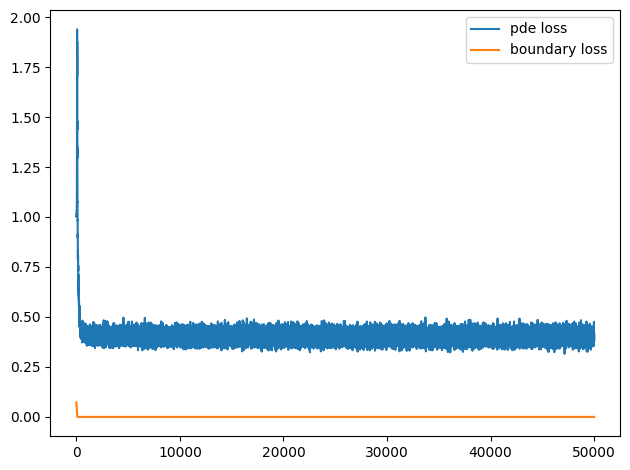

In [13]:

pinn = PINN(d=dim, m=10, n=4, beta=1000)

pinn.train_problem(problem=problem, steps=num_steps, in_bs=in_bs, bd_bs=bd_bs, lr=lr, opt_type="adam", log_every=log_every)


在测试点上计算网络的结果，并可视化结果

/tmp/ipykernel_2670703/472253314.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


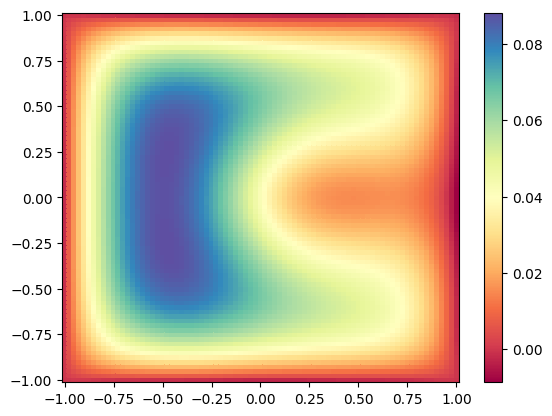

In [14]:

pinn.net.eval()
with torch.no_grad():
    u_grid = pinn.net(torch.from_numpy(grid)).detach().numpy()

fig, ax = plt.subplots()

im = ax.pcolor(grid[:, :, 0], grid[:, :, 1], u_grid[:, :, 0], cmap="Spectral")
fig.colorbar(im)

fig.show()


输出网路训练完成后 PDE 强形式损失以及边界损失

In [15]:

in_size = 1000
bd_size = 200

# inner conditions
x_in = problem.sample_inner(in_size)
x_in = torch.from_numpy(x_in).requires_grad_(True)
u_in = pinn.net(x_in)
loss_in = problem.pinn_loss_inner(u_in, x_in)

# boundary conditions
x_bd = problem.sample_boundary(bd_size)
x_bd = torch.from_numpy(x_bd).requires_grad_(True)
u_bd = pinn.net(x_bd)
loss_bd = problem.pinn_loss_boundary(u_bd, x_bd)

print(f"loss inner: {loss_in.mean()}")
print(f"loss bound: {loss_bd.mean()}")

loss inner: 0.3934787555906693
loss bound: 5.000905687386219e-05
